In [ ]:
!unzip train.zip

In [2]:
import numpy as np
import keras

In [3]:
# load sample images from directory

def load_images(dir_path, color_info):

  from keras.utils import image_dataset_from_directory

  dataset = image_dataset_from_directory(
      directory = dir_path, labels=None,
      color_mode = color_info, image_size=(256, 256)
  )
  return dataset


In [4]:
dataset = load_images('train', 'rgb')

Found 245 files.


In [5]:
# convert tf dataset into numpy array
def tfdata_to_numpy(dataset):
  numpy_data = []
  for batch in dataset:
      numpy_data.append(batch.numpy())
  return np.concatenate(numpy_data, axis=0)

In [6]:
color_images = tfdata_to_numpy(dataset)
color_images.shape

(245, 256, 256, 3)

In [7]:
# plot given sample of images

def plot_images(images, color_mode='viridis'):
  import matplotlib.pyplot as plt

  n = len(images)
  plt.figure(figsize=(15, 15))
  for k in range(n):
    plt.subplot(1, n, k+1)
    plt.imshow(images[k], cmap=color_mode)
    plt.xticks([])
    plt.yticks([])


In [8]:
def preprocess_images(images):
  images = images.astype('float32') / 255.0
  return images

In [9]:
color_images = preprocess_images(color_images)

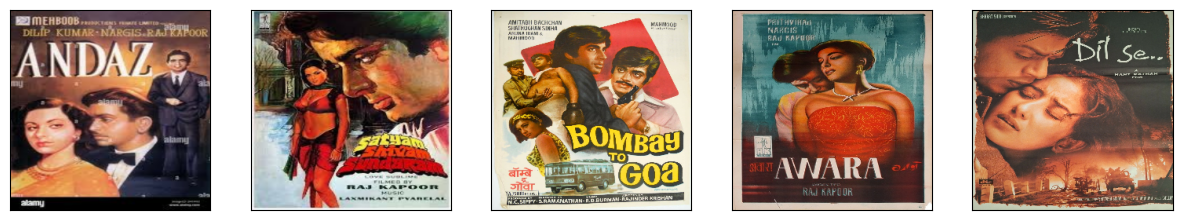

In [10]:
plot_images(color_images[:5])

In [11]:
# convert RGB images to LAB

def rgb_to_lab(rgb_images):

  from skimage import color
  image_lab = color.rgb2lab(rgb_images)
  L = image_lab[:, :, :, 0] / 100.0
  AB = image_lab[:, :, :, 1:] / 128.0
  return L, AB

In [12]:
# get L and AB components
train_l, train_ab = rgb_to_lab(color_images)
train_l.shape
train_ab.shape

(245, 256, 256, 2)

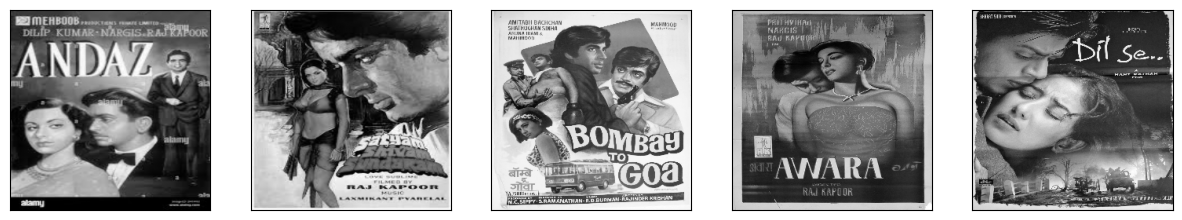

In [13]:
plot_images(train_l[:5], 'gray')

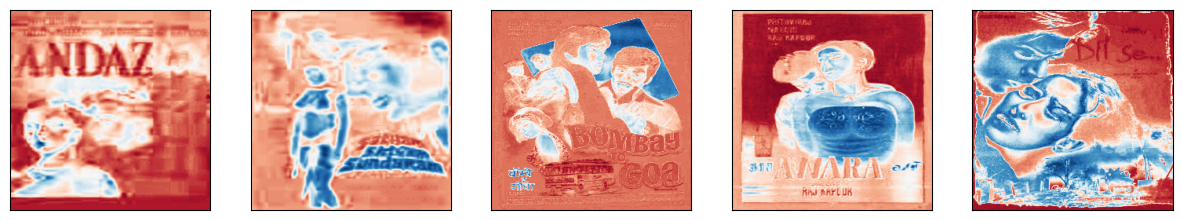

In [14]:
plot_images(train_ab[:5, :, : , 0], color_mode='RdBu')

In [15]:
# encoder decoder model to colorize grayscale images

from keras import layers

inputs = keras.Input(shape=(256, 256, 1))

# encoder layers
conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', strides=2)(inputs)
conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)(conv1)

# bottleneck or latent layer
latent_layer = layers.Conv2D(128, 3, activation='relu', padding='same', strides=2)(conv2)

# decoder layers
up1 = layers.UpSampling2D((2,2))(latent_layer)
concat1 = layers.Concatenate()([up1, conv2])
dec1 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)

up2 = layers.UpSampling2D((2,2))(dec1)
concat2 = layers.Concatenate()([up2, conv1])
dec2 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat2)

up3 = layers.UpSampling2D((2,2))(dec2)
dec3 = layers.Conv2D(2, 3, activation='tanh', padding='same')(up3)

colorizer = keras.Model(inputs=inputs, outputs=dec3)
colorizer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 256, 256,  │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │        578 │ up_sampling2d_2[… │
│                     │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,586 (904.63 KB)

 Trainable params: 231,586 (904.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model on Luminance (L) as input
# and corresponding AB components as output

colorizer.compile(loss='mse', optimizer='adam', metrics=(['accuracy']))
colorizer.fit(train_l, train_ab, epochs=30, validation_split=0.2)

In [ ]:
!unzip test.zip

In [18]:
# load test images
from keras.utils import load_img

test_sample = []
n = 10

for k in range(n):
    img_file = "test/" + str(k+1) + ".jpg"
    test_img = load_img(img_file, target_size=(256, 256))
    test_sample.append(test_img)

np.array(test_sample).shape

(10, 256, 256, 3)

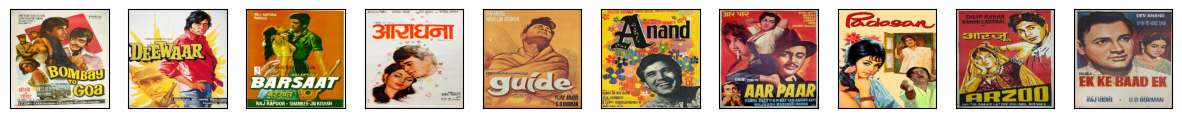

In [19]:
plot_images(test_sample)

In [20]:
test_sample = preprocess_images(np.array(test_sample))
test_l, test_ab = rgb_to_lab(test_sample)
test_ab.shape

(10, 256, 256, 2)

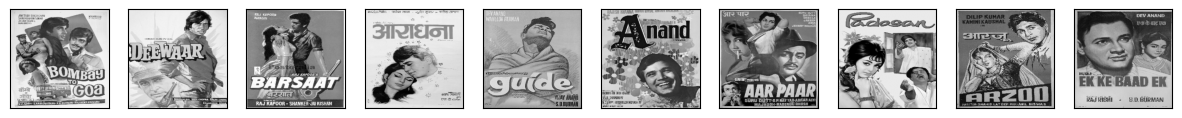

In [21]:
plot_images(test_l, 'gray')

In [22]:
# convert LAB images to RGB
def lab_to_rgb(L, AB):

  rgb_images = []
  from skimage import color
  for k in range(len(L)):

    image_lab = np.zeros((256, 256, 3))
    image_lab[:, :, 0] = L[k] * 100
    image_lab[:, :, 1:] = AB[k] * 128

    image_rgb = color.lab2rgb(image_lab)
    rgb_images.append(image_rgb)
  return np.array(rgb_images)

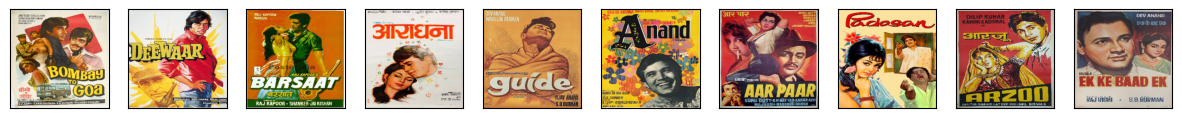

In [23]:
# test conversion process from LAB to RGB
test_rgb = lab_to_rgb(test_l, test_ab)
plot_images(test_rgb)

In [24]:
# pass L to colorizer model to get A B
y_ab = colorizer.predict(test_l)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


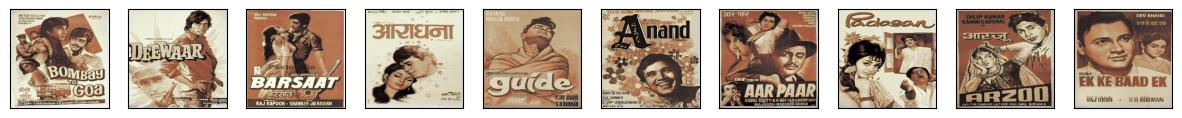

In [25]:
# use predicted AB parameters to reconstruct RGB
y = lab_to_rgb(test_l, y_ab)
plot_images(y)

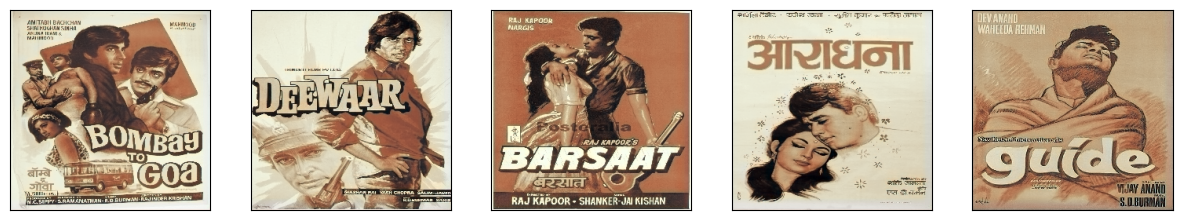

In [26]:
plot_images(y[:5, :, :, :])